In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
from IPython import display
from utils import Registro

In [2]:
directorio = './torch_data/RGA'
compose = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.5], [0.5])])
# Cargar los datos
datos = datasets.MNIST(root='{}/dataset'.format(directorio), train=True, transform=compose, download=True)
# Crear un cargador con los datos, para poder iterar sobre ellos
cargador = torch.utils.data.DataLoader(datos, batch_size=100, shuffle=True)
# Numero de lotes(batch)
n_lotes = len(cargador)


Extracting ./torch_data/RGA/dataset\MNIST\raw\train-images-idx3-ubyte.gz to ./torch_data/RGA/dataset\MNIST\raw




Extracting ./torch_data/RGA/dataset\MNIST\raw\train-labels-idx1-ubyte.gz to ./torch_data/RGA/dataset\MNIST\raw




Extracting ./torch_data/RGA/dataset\MNIST\raw\t10k-images-idx3-ubyte.gz to ./torch_data/RGA/dataset\MNIST\raw




Extracting ./torch_data/RGA/dataset\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./torch_data/RGA/dataset\MNIST\raw



In [3]:
in_G=100
in_D=784
# Ruido Z
def ruido(size):
    return Variable(torch.randn(size, 100))

class Generador(torch.nn.Module):
    def __init__(self):
        super(Generador, self).__init__()
        self.hidden0 = nn.Sequential(nn.Linear(in_G, 256),nn.LeakyReLU(0.2))
        self.hidden1 = nn.Sequential(nn.Linear(256, 512),nn.LeakyReLU(0.2))
        self.hidden2 = nn.Sequential(nn.Linear(512, 1024),nn.LeakyReLU(0.2))
        self.out = nn.Sequential(nn.Linear(1024, in_D),nn.Tanh())

    def forward(self, x):
        return self.out(self.hidden2(self.hidden1(self.hidden0(x))))
    
class Discriminador(torch.nn.Module):
    def __init__(self):
        super(Discriminador, self).__init__()
        self.hidden0 = nn.Sequential(nn.Linear(in_D, 1024),nn.LeakyReLU(0.2),nn.Dropout(0.3))
        self.hidden1 = nn.Sequential(nn.Linear(1024, 512),       nn.LeakyReLU(0.2),nn.Dropout(0.3))
        self.hidden2 = nn.Sequential(nn.Linear(512, 256),        nn.LeakyReLU(0.2),nn.Dropout(0.3))
        self.out=nn.Sequential(torch.nn.Linear(256, 1),torch.nn.Sigmoid())

    def forward(self, x):
        return self.out(self.hidden2(self.hidden1(self.hidden0(x))))


D = Discriminador()
G = Generador()

In [4]:
# Funcion de coste
coste = nn.BCELoss()

def entrenar_G(optimizador, datos_G):
    # Restablecer gradientes
    optimizador.zero_grad()
    # Muestrear el ruido y generar datos falsos
    prediccion_G = D(datos_G)
    # Calcular la perdida (etiquetas = tensor de 1s) y retropropagar
    perdida = coste(prediccion_G, Variable(torch.ones(prediccion_G.size(0), 1)))
    perdida.backward()
    # Actualizar los pesos con los gradientes
    optimizador.step()
    return perdida

def entrenar_D(optimizador, datos_X, datos_G):
    # Restablecer gradientes
    optimizador.zero_grad()
    # Entrenar con datos reales
    prediccion_X = D(datos_X)
    # Calcular la perdida (etiquetas = tensor de 1s) y retropropagar
    perdida_X = coste(prediccion_X, Variable(torch.ones(datos_X.size(0), 1)))
    perdida_X.backward()
    # Entrenar con datos falsos
    prediccion_G = D(datos_G)
    # Calcular la perdida (etiquetas = tensor de 0s) y retropropagar
    perdida_G = coste(prediccion_G, Variable(torch.zeros(datos_X.size(0), 1)))
    perdida_G.backward()
    # Actualizar los pesos con los gradientes
    optimizador.step()
    return perdida_X + perdida_G, prediccion_X, prediccion_G


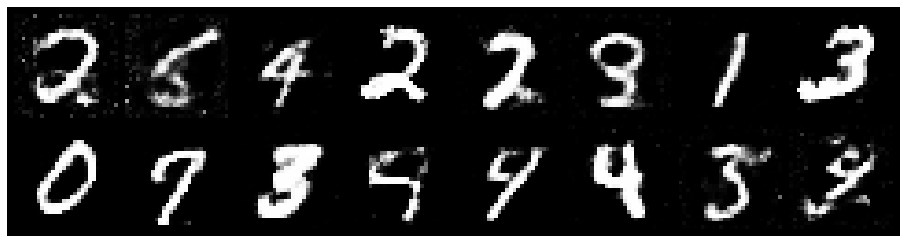

Epoca: [199/200], Numero de Lote: [500/600]
D(G(z)): 0.4812, D(G(x)): 0.5665
Perdida Discriminador: 1.3498, Perdida Generador: 1.3498


In [6]:
costes_D=[]
costes_G=[]

def img_vect(img):
    return img.view(img.size(0), 784)

def vect_img(vect):
    return vect.view(vect.size(0), 1, 28, 28)

# Optimizador
optimizador_G = optim.Adam(G.parameters(), lr=0.0002)
optimizador_D = optim.Adam(D.parameters(), lr=0.0002)
# Numero de pasos a aplicar al discriminador
pasos_D = 1
# Numero de epocas
n_epocas = 200

#Generar muestras para las pruebas
n_muestras = 16
ruido_entrada = ruido(n_muestras)
registro = Registro(nombre_modelo='RGA', nombre_datos='MNIST')

for epoca in range(n_epocas):
    for lote, (lote_r,_) in enumerate(cargador):

        #Entrenamiento del Discriminador
        datos_X = Variable(img_vect(lote_r))
        datos_G = G(ruido(datos_X.size(0))).detach()
        perdida_D, prediccion_X, prediccion_G = entrenar_D(optimizador_D,datos_X, datos_G)

        #Entrenamiento del Generador
        datos_G = G(ruido(lote_r.size(0)))
        perdida_G = entrenar_G(optimizador_G, datos_G)
        
        # Registrar error
        registro.registrar(perdida_D, perdida_D, epoca, lote, n_lotes)

        # Mostrar el progreso
        if (lote) % 100 == 0:
            display.clear_output(True)
            # Mostrar imagenes
            test_images = vect_img(G(ruido_entrada)).data.cpu()
            registro.registrar_imagenes(test_images, n_muestras, epoca, lote, n_lotes);
            # Mostrar registros de estado
            registro.mostrar_estado(epoca, n_epocas, lote, n_lotes, perdida_D, perdida_D, prediccion_X, prediccion_G)
        
        # Puntos de control del modelo
        registro.guardar_modelos(G, D, epoca)
        
        #Para las graficas
        costes_D.append(perdida_D)
        costes_G.append(perdida_G)

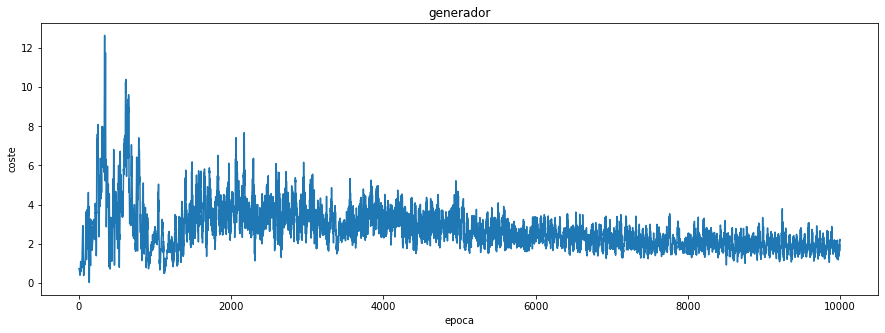

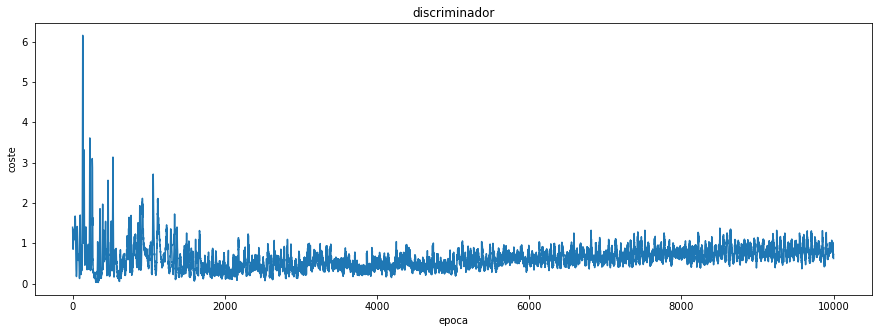

In [30]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(15,5))
plt.plot(list(map(lambda x: x.detach().numpy(), costes_G[0:10000])))
plt.xlabel('epoca')
plt.ylabel('coste')
plt.title('generador')
plt.show()
fig = plt.figure(figsize=(15,5))
plt.plot(list(map(lambda x: x.detach().numpy(), costes_D[0:10000])))
plt.xlabel('epoca')
plt.ylabel('coste')
plt.title('discriminador')
plt.show()

print(costes_G[0].detach().numpy())

In [20]:
result=map(lambda x: x.detach().numpy(), costes_G[0:10])
print(list(result))

[array(0.72171366, dtype=float32), array(0.71554655, dtype=float32), array(0.7087361, dtype=float32), array(0.69737434, dtype=float32), array(0.68077654, dtype=float32), array(0.6534027, dtype=float32), array(0.6186728, dtype=float32), array(0.5739307, dtype=float32), array(0.52527356, dtype=float32), array(0.47165406, dtype=float32)]
